<a href="https://colab.research.google.com/github/Maoelan/Second-Project_Time-Series_TensorFlow-Dicoding-/blob/main/Second_Project_Time_Series_TensorFlow_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = pd.read_csv('/content/drive/MyDrive/dataset/raw_sales.csv')

Dataset : https://www.kaggle.com/datasets/htagholdings/property-sales

In [3]:
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


In [4]:
data.tail()

,datesold,postcode,price,propertyType,bedrooms
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2
29579,2019-07-26 00:00:00,2612,775000,unit,2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [6]:
date_sold = data['datesold'].values
price = data[['price']].values

Text(0.5, 1.0, 'Price for which the property was sold')

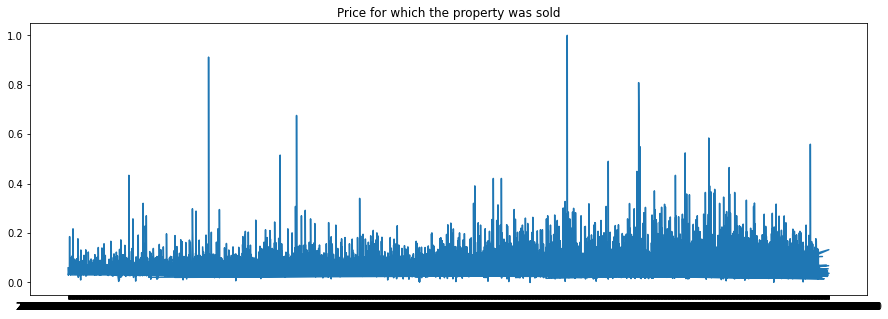

In [24]:
plt.figure(figsize=(15,5))
plt.plot(date_sold,price)
plt.title('Price for which the property was sold')

In [8]:
min_max_scaler = MinMaxScaler()
price = min_max_scaler.fit_transform(price)

In [9]:
price

array([[0.05897904],
       [0.0293951 ],
       [0.03417889],
       ...,
       [0.0514194 ],
       [0.06703594],
       [0.09045131]])

In [11]:
threshold_mae = (price.max() - price.min()) * 10/100
threshold_mae

0.09999999999999998

In [13]:
dates_train, dates_val, price_train, price_val = train_test_split(date_sold, price, test_size=0.2, shuffle=False)

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
train_set = windowed_dataset(price_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(price_val, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60, input_shape=(None,1), return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.020):
      print("\nMae < 2% keseluruhan data")
      self.model.stop_training = True
callbacks = myCallback()

In [20]:
history = model.fit(train_set, epochs=100, validation_data=(val_set), callbacks=[callbacks])

Epoch 1/100
237/237 [==============================] - 74s 309ms/step - loss: 6.2153e-04 - mae: 0.0224 - val_loss: 8.2130e-04 - val_mae: 0.0363
Epoch 2/100
237/237 [==============================] - 40s 170ms/step - loss: 6.1896e-04 - mae: 0.0223 - val_loss: 8.1760e-04 - val_mae: 0.0362
Epoch 3/100
237/237 [==============================] - 40s 169ms/step - loss: 6.1828e-04 - mae: 0.0223 - val_loss: 8.0988e-04 - val_mae: 0.0360
Epoch 4/100
237/237 [==============================] - 42s 176ms/step - loss: 6.1713e-04 - mae: 0.0222 - val_loss: 8.4664e-04 - val_mae: 0.0369
Epoch 5/100
237/237 [==============================] - 43s 179ms/step - loss: 6.1905e-04 - mae: 0.0223 - val_loss: 8.2635e-04 - val_mae: 0.0364
Epoch 6/100
237/237 [==============================] - 43s 181ms/step - loss: 6.1850e-04 - mae: 0.0223 - val_loss: 8.4921e-04 - val_mae: 0.0370
Epoch 7/100
237/237 [==============================] - 40s 170ms/step - loss: 6.1989e-04 - mae: 0.0224 - val_loss: 7.9246e-04 - val_mae:

In [21]:
model.evaluate(val_set)

59/59 [==============================] - 4s 71ms/step - loss: 8.9441e-04 - mae: 0.0381


[0.000894408964086324, 0.03813822567462921]

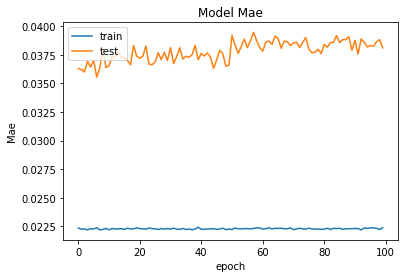

In [22]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

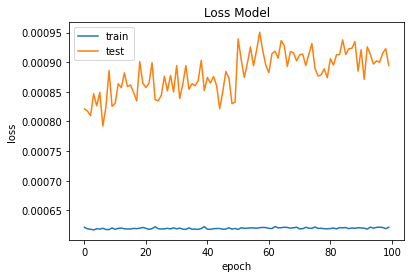

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()